grabbing waveforms for 20210205


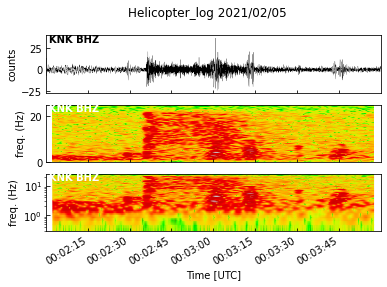

In [1]:
from obspy.clients.fdsn import Client
client_wm = Client("IRIS")
from obspy import read
from obspy import Stream
from obspy import UTCDateTime
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime


# LOAD WAVEFORM DATA. DO A LITTLE PRE-PROCESSING
#tday = UTCDateTime("2021-08-09 07:45") #landslide
#tday = UTCDateTime("2021-10-12 22:20") #helo landing
#tday = UTCDateTime("2021-03-28T02:31:00.000")
#tday = UTCDateTime("2021-06-30 21:49") # good eq signal on CHN
#tday = UTCDateTime("2021-10-11 09:10:24.000") #chignik
#tday = UTCDateTime("2015-10-18 05:17:00.000") #taan fjord
tday = UTCDateTime("2021-02-5T00:02:00.000")

event_name = "Helicopter_log"
print('grabbing waveforms for ' + tday.strftime("%Y%m%d"))
#st = client_wm.get_waveforms("AK", "BAE", "*", "BHZ", tday, tday+780, attach_response=True)
st = client_wm.get_waveforms("AK", "KNK", "*", "BHZ", tday, tday+120, attach_response=True)
#st.remove_response(output='VEL')
#print(st[0].stats.response)

#nos = len(st)
#for s in range(nos):
#    print(st[s].stats)
st.detrend("linear")
st.detrend("demean")
st.filter('highpass', freq=2.0)
#print(st[0].stats)

fig, (ax1, ax2, ax3) = plt.subplots(3,1)   
#fig, (ax1, ax2) = plt.subplots(2,1)   
date_format = mdates.DateFormatter('%H:%M:%S')
timevector = st[0].times("matplotlib")

#st.plot()
ax1.plot(st[0].times("matplotlib"),st[0].data,'-',color='k',lw=.2)
ax1.xaxis.set_major_formatter(date_format)
#ax1.xaxis.set_minor_locator(minutes)
ax1.xaxis_date()
ax1.tick_params(direction='in')
ax1.axes.xaxis.set_ticklabels([])
ax1.set_xlim(timevector[0], timevector[-1]) 
ax1.set_ylabel('counts')
ax1.set_xlabel("Time [UTC]" )
text = (st[0].stats.station)+' '+(st[0].stats.channel)
ax1.text(0.01, 0.88, text, transform=ax1.transAxes, fontsize=10, fontweight='bold', color='black')

# PLOT SPECTROGRAM USING SCIPY SPECTROGRAM CALCULATIONS
fxx, txx, Sxx = signal.spectrogram(st[0].data, fs=st[0].stats.sampling_rate, mode='psd', window=('tukey', 10), nperseg=256, noverlap=250, scaling='density')
#Sxx = np.flipud(Sxx) #not sure if this is needed but this is for imshow
Sxx = 10*np.log10(Sxx)
#extent = (timevector[0], timevector[-1], fxx[0], fxx[-1])#for imshow
#h = ax2.imshow(Sxx, extent=extent, aspect='auto', cmap='nipy_spectral', vmin=-40, vmax=80) 

#hackish way to change txx time array into UTC
points = txx.shape[0]
t = [datetime.datetime(tday.year,tday.month,tday.day,tday.hour,tday.minute,tday.second) + datetime.timedelta(seconds=(txx[i])) for i in range(points)]

h = ax2.pcolormesh(t, fxx, Sxx, shading='gouraud', cmap='nipy_spectral', vmin=np.min(Sxx), vmax=np.max(Sxx))


######ADD COLORBAR NEXT TO AX2, THIS WORKS BUT THEN WAVEFORM TIME SCALE DOESN'T MATCH WITH SPECTOGRAM
#####fig.colorbar(h, ax=ax2)

#ax2.set_yscale('log')
#ax2.set_ylim(fxx[0],fxx[-1])
ax2.set_xlim(timevector[0], timevector[-1]) 
ax2.xaxis.set_major_formatter(date_format)
ax2.xaxis_date()
ax2.tick_params(direction='in')
ax2.axes.xaxis.set_ticklabels([])

ax2.set_ylabel('freq. (Hz)')
#ax2.set_xlabel("Time [UTC]" )
ax2.text(0.01, 0.88, text, transform=ax2.transAxes, fontsize=10, fontweight='bold', color='white')


#THIS IS ALL ADAPTED FROM OBSPYS SPECTOGRAM CODE TO PLOT LOG SCALE. NOT SURE HOW IT WORKS. 
#print(Sxx.shape)
Sxx= Sxx[1:, :]
#print(Sxx.shape)
fxx = fxx[2:]
t = t[1:]
halfbin_t = (t[1] - t[0]) / 2.0
halfbin_fxx = (fxx[1] - fxx[0]) / 2.0

fxx = np.concatenate((fxx, [fxx[-1] + 2 * halfbin_fxx]))
t = np.concatenate((t, [t[-1] + 2 * halfbin_t]))
# center bin
t -= halfbin_t
fxx -= halfbin_fxx
# Log scaling for frequency values (y-axis)
ax3.set_yscale('log')
# Plot times
 

h = ax3.pcolormesh(t, fxx, Sxx, shading='gouraud', cmap='nipy_spectral', vmin=np.min(Sxx), vmax=np.max(Sxx))

###ADD COLORBAR TO AX WHICH YOU CAN CONTROL THE LOCATION OF: 
###ax33 = fig.add_axes([0.83, 0.15, 0.03, 0.1])
####fig.colorbar(h, ax=ax33)


#plt.yscale('symlog')
#ax2.set_yscale('log')
#ax2.set_ylim(fxx[0],fxx[-1])
ax3.set_xlim(timevector[0], timevector[-1]) 
ax3.xaxis.set_major_formatter(date_format)
ax3.xaxis_date()
ax3.tick_params(direction='in')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('freq. (Hz)')
ax3.set_xlabel("Time [UTC]" )
ax3.text(0.01, 0.88, text, transform=ax3.transAxes, fontsize=10, fontweight='bold', color='white')
#
#

fig.autofmt_xdate()
fig.suptitle(event_name + ' ' + tday.strftime("%Y/%m/%d"))
fig.savefig(event_name + '_spectogram_scipy', bbox_inches='tight')
